In [57]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
import datetime
from ipywidgets import interact, Dropdown, SelectionSlider, widgets
from IPython.display import display, clear_output
from preprocessing import apply_complete_preprocessing
from datasets import load_processed_data, update_processed_data
from bbdatasets import *

## Table of Contents
1. [Load the data](#I.-Load-the-data)
    - [A. Load All Channel Data](#1.-Load-All-Channel-Data)
    - [B. Load Selected Bad Buzz Channel Data](#2.-Load-Selected-Bad-Buzz-Channel-Data)
2. [Data Analysis on Bad Buzz Data](#II.-Data-Analysis-on-Bad-Buzz-Data)
    - [A. Subscribers Analysis](#A.-Subscribers-Analysis)
    - [B. Views Analysis around Detected Bad Buzz](#B.-Views-Analysis-around-Detected-Bad-Buzz)
    - [C. Likes/Dislikes Analysis around Detected Bad Buzz ](#C.-Likes/Dislikes-Analysis-around-Detected-Bad-Buzz)
    - [D. Activity around the BB](#D.-Activity-around-the-BB)
3. [Data Analysis on All Dataset](#III.-Data-Analysis-On-All-Dataset)
4. [Conclusion](#conclusion)

# I. Load the data

- i have a dataset that gathers all channels that have suffered at least once of a bad buzz 
- GOAL : find a general method that can find the bad buzz
- HOW CAN I DO IT ? 
    - i have the list of channels with the date of the bb 
    - i need to find these dates thanks to a statistical analysis 
    - i have for each pair of channel and week index : 
        - `category`
        - `views` : Total number of views the channel had this week.
        - `delta_views` : Delta views obtained this week.
        - `subs` : Total number of subscribers the channel had this week.
        - `delta_subs` : Delta subscribers obtained this week.
        - `number of videos` : Total number of videos the channel had this week.
        - `delta_videos` : Delta videos obtained this week.
        - `activity` : number of videos posted this week 
        - `view_count` => number of views f viedos posted
        - `like_count` => number of likes on pposted video 
        - `dislike_count` => number of dislikes on pposted video 

BAD BUZZ INDICATORS : 
    - increase in dislike count 
    - drop in subscriber growth or loss of subscribers
    - decrease in views or view growth 
    - changes in likes/dislikes ratios : higher dislikes ratio 
    - changes in number of videos posted, fewer views despite more content 

## 1. Load All Channel Data 

In [58]:
def week_index_to_date(week_index):
    # Base date corresponding to week index 0
    base_date = datetime.datetime(2015, 1, 5)
    
    # Calculate the date by adding the number of weeks to the base date
    target_date = base_date + datetime.timedelta(weeks=week_index)
    
    return target_date

In [59]:
# decomment the next line if we need to update the preprocessed data 
# update_processed_data(verbose=True)
original_data = load_processed_data(verbose=True)

Loading data in chunks of 1000: 100%|█████████▉| 18598/18604.825 [01:38<00:00, 184.42it/s]c:\Users\eva\anaconda3\envs\ada\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Loading data in chunks of 1000: 100%|██████████| 18605/18604.825 [01:38<00:00, 187.98it/s]


Loaded 18604824 rows


In [60]:
nb_channels = original_data.reset_index()['channel'].nunique()
print(f'Number of channels : {nb_channels}')
print(f'Columns name :\n {original_data.columns}')

Number of channels : 133516
Columns name :
 Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count',
       'dislike_count'],
      dtype='object')


In [61]:
min_week_index_original = original_data.reset_index()['week'].min()
max_week_index_original = original_data.reset_index()['week'].max()

print(f'The minimum week index is {min_week_index_original} and corresponds to the date : {week_index_to_date(min_week_index_original)}')
print(f'The maximum week index is {max_week_index_original} and corresponds to the date : {week_index_to_date(max_week_index_original)}')

The minimum week index is 0 and corresponds to the date : 2015-01-05 00:00:00
The maximum week index is 247 and corresponds to the date : 2019-09-30 00:00:00


## 2. Load Selected Bad Buzz Channel Data 

In [62]:
# decomment the next line if we need to update the preprocessed data 
# update_processed_bb_timeseries(verbose=True)
data = load_bb_timeseries_processed(verbose=True)

Loading data in chunks of 1000: 6it [00:00, 134.67it/s]                  

Loaded 5030 rows


In [63]:
nb_channels = data.reset_index()['channel'].nunique()
print(f'Number of channels : {nb_channels}')
print(f'Columns name :\n {data.columns}')

Number of channels : 33
Columns name :
 Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count',
       'dislike_count'],
      dtype='object')


In [64]:
min_week_index = data.reset_index()['week'].min()
max_week_index = data.reset_index()['week'].max()

print(f'The minimum week index is {min_week_index} and corresponds to the date : {week_index_to_date(min_week_index)}')
print(f'The maximum week index is {max_week_index} and corresponds to the date : {week_index_to_date(max_week_index)}')

The minimum week index is 91 and corresponds to the date : 2016-10-03 00:00:00
The maximum week index is 247 and corresponds to the date : 2019-09-30 00:00:00


# II. Data Analysis On BB Data

## A. Subscribers Analysis
The first stop of our analysis is to detect the sudden subscriber losses.

### 1. Plot for each channel the evolution of the number of subscribers

In [65]:
# TODO : convert the week indices into real date ? 
# TODO : check title and axes label 

def plot_subs_by_channel(channel, df): 
    plt.figure(figsize=(15, 5))
    
    df = df.xs(channel, level='channel')
    
    sns.lineplot(data=df, x='week', y='subs', label='Subscribers')
    
    plt.xlabel("Week index")
    plt.ylabel("Subscribers")
    plt.title(f"Subscriber Trends for {channel}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [66]:
# Create a SelectionSlider widget for selecting channels
channel_selector = SelectionSlider(
    options=data.index.get_level_values('channel').unique(),
    description='Channel:',
    disabled=False
)

In [67]:
interactive_plot_subs = widgets.interactive_output(plot_subs_by_channel, {'channel': channel_selector, 'df': widgets.fixed(data)})
display(channel_selector, interactive_plot_subs)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

### 2. Rolling average analysis
Since the big YouTube channels in our dataset typically experience consistent subscriber growth, they rarely face actual decreases in their total subscriber count. However, a significant slowdown in the growth rate can still be considered a negative event, as it may indicate potential issues such as reduced engagement or a negative reception by the audience. To detect these sharp declines in subscriber growth, we compare the actual growth rate (`delta_subs`) against the rolling average growth rate (`rolling_growth_rate`).\
The rolling average acts as a smoothed baseline, calculated using a defined window (we arbitrarily used a `ROLLING_WINDOW` of 20 weeks), which helps to identify deviations from the expected trend. When the actual growth rate falls below the rolling average, it suggests that the channel's performance has dipped relative to its typical trend. This comparison enables us to highlight periods of concern where the channel's momentum weakens, which could signal the start of a "bad buzz" or other negative factors impacting channel performance.

In [68]:
# TODO : faire une méthode pour calculer la rolling avg et détecter le début des bb 

In [69]:
ROLLING_WINDOW = 20
THRESHOLD_BB = 0 #TODO: try to modify it so that it doesn't detect the small BB

data['rolling_growth_rate'] = data.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())
data['growth_diff'] = data['delta_subs'] - data['rolling_growth_rate']

# Detection of period where growth_rate < rolling_growth_rate
data['is_bad_buzz'] = data['growth_diff'] < THRESHOLD_BB
# Create a DataFrame that contains only the starting week of each BBC
bad_buzz_starts = []

# For loop to detect the starting week of BB
for channel in data.reset_index()['channel'].unique():
    channel_data = data.reset_index()[data.reset_index()['channel'] == channel]
    
    # Identify indices where BB has started
    for i in range(1, len(channel_data)):
        if channel_data['is_bad_buzz'].iloc[i] and not channel_data['is_bad_buzz'].iloc[i-1]:
            bad_buzz_starts.append({'channel': channel, 'week': channel_data['week'].iloc[i]})

bad_buzz_df = pd.DataFrame(bad_buzz_starts).reset_index()[['channel', 'week']]

max_nb_bb = bad_buzz_df.groupby('channel').count()['week'].max()
print(f'A channel has a maximum of {max_nb_bb}')

bad_buzz_df

A channel has a maximum of 22


,channel,week
0,UC-lHJZR3Gqxm24_Vd_AJ5Yw,95
1,UC-lHJZR3Gqxm24_Vd_AJ5Yw,104
2,UC-lHJZR3Gqxm24_Vd_AJ5Yw,112
3,UC-lHJZR3Gqxm24_Vd_AJ5Yw,130
4,UC-lHJZR3Gqxm24_Vd_AJ5Yw,137
...,...,...
499,UCzKc6JrWSt_67UpEYIefrJQ,182
500,UCzKc6JrWSt_67UpEYIefrJQ,188
501,UCzKc6JrWSt_67UpEYIefrJQ,198
502,UCzKc6JrWSt_67UpEYIefrJQ,205


In order to get the periods of concern, we save in the dataframe `bad_buzz_df` the first week index of the period where growth_rate < rolling_growth_rate.

In [70]:
def plot_rolling_growth_rate(channel, df, bad_buzz_df): 
    df_plot = df.xs(channel, level='channel')
    
    clear_output(wait=True)
    plt.figure(figsize=(15, 5))
    
    sns.lineplot(data=df_plot, x='week', y='delta_subs', label='Delta Subscribers', color='blue')
    sns.lineplot(data=df_plot, x='week', y='rolling_growth_rate', label='Rolling Growth Rate', color='orange')
    
    plt.fill_between(df_plot.reset_index()['week'], df_plot['delta_subs'], df_plot['rolling_growth_rate'], 
                    where=(df_plot['delta_subs'] < df_plot['rolling_growth_rate']), 
                    color='red', alpha=0.3, label='Potential Bad Buzz')

    # Plot vertical lines for bad buzz weeks
    bad_buzz_weeks = bad_buzz_df[bad_buzz_df['channel'] == channel]['week']
    for week in bad_buzz_weeks:
        plt.axvline(x=week, color='green', linestyle='--', alpha=0.7, label='Bad Buzz' if week == bad_buzz_weeks.iloc[0] else "")
    
    plt.xlabel('Week')
    plt.ylabel('Growth Rate')
    plt.title(f'Delta Subscribers and Rolling Growth Rate for Channel {channel}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


In [71]:
interactive_plot_subs_roll_avg = widgets.interactive_output(plot_rolling_growth_rate, {'channel': channel_selector,
                                                                                       'df': widgets.fixed(data), 
                                                                                       'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_subs_roll_avg)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

Now that we detected periods of concern that are potential "bad buzz", we want to see if the change of growth rate correlates with other engagement metrics or events. Specifically, we aim to identify relationships between these slowdowns in subscriber growth and various possible influencing factors such as:
- Number of views
- Like/Dislike ratio
- Activity

## B. Views Analysis around Detected Bad Buzz 
During this part of the analysis, we want to visualize changes in views around the periods of interest detected previously, to explore the behavior of `delta_views` around the identified periods for each YouTube channel.\
We use the `define_periods` function to divide the data into:
- Pre-buzz: 10 weeks leading up to the bad buzz event.
- During-buzz: The 8-week period starting from the bad buzz week.
- Post-buzz: The following 10 to 20 weeks post-buzz.


### 1. Delta Views Evolution

In [72]:
def plot_views_around_bad_buzz(channel, df, bad_buzz_df): 
    df_plot = df.xs(channel, level='channel').reset_index()
    
    clear_output(wait=True)
    plt.figure(figsize=(15, 5))
    
    sns.lineplot(data=df_plot, x='week', y='delta_views', label='Delta Views', color='blue')
    
    # Plot vertical lines for bad buzz weeks
    bad_buzz_weeks = bad_buzz_df[bad_buzz_df['channel'] == channel]['week']
    for week in bad_buzz_weeks:
        plt.axvline(x=week, color='green', linestyle='--', alpha=0.7, label='Bad Buzz' if week == bad_buzz_weeks.iloc[0] else "")
    
    plt.xlabel('Week')
    plt.ylabel('Views')
    plt.title(f'Views Around Bad Buzz Weeks for Channel {channel}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [73]:
interactive_plot_views = widgets.interactive_output(plot_views_around_bad_buzz, {'channel': channel_selector, 
                                                                                'df': widgets.fixed(data), 
                                                                                'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_views)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

#### 2. One Channel

In [74]:
def normalize_week_indices(df, week):
    df['relative_week'] = df['week'] - week
    return df

def define_periods(df):
    pre_buzz = df[(df['relative_week'] < 0) & (df['relative_week'] >= -10)]
    during_buzz = df[(df['relative_week'] >= 0) & (df['relative_week'] <= 8)]
    post_buzz = df[(df['relative_week'] > 10) & (df['relative_week'] <= 20)]
    return pre_buzz, during_buzz, post_buzz

def calculate_averages(pre_buzz, during_buzz, post_buzz):
    avg_pre_buzz_views = pre_buzz['delta_views'].mean()
    avg_during_buzz_views = during_buzz['delta_views'].mean()
    avg_post_buzz_views = post_buzz['delta_views'].mean()
    return avg_pre_buzz_views, avg_during_buzz_views, avg_post_buzz_views

def perform_t_test(pre_buzz, during_buzz):
    t_stat, p_value = ttest_ind(during_buzz['delta_views'], pre_buzz['delta_views'], equal_var=False)
    return p_value

def plot_results(ax, df, avg_pre_buzz_views, week, p_value, rolling_window=10, pos_p_value=-0.15):
    ax.plot(df['relative_week'], df['delta_views'], label='Delta Views', color='blue')
    ax.plot(df['relative_week'], df['delta_views'].rolling(rolling_window).mean(), label='Rolling Avg (Views)', color='orange')
    ax.axvline(x=0, color='red', linestyle='--', label='Bad Buzz Start')
    ax.axhline(y=avg_pre_buzz_views, color='green', linestyle='--', label='Pre-Buzz Avg')
    
    ax.set_title(f"Delta Views around Bad Buzz (Week {week})")
    ax.set_xlabel('Weeks')
    ax.set_ylabel('Delta Views')
    ax.legend()
    
    # Add p-value text
    ax.text(0.5, pos_p_value, f'p-value: {p_value:.4f}', transform=ax.transAxes, ha='center', va='center')

def analyze_views_around_bad_buzz(channel, df, bad_buzz_df, pos_p_value=-0.25):
    df_plot = df.xs(channel, level='channel').reset_index()
    bad_buzz_weeks = bad_buzz_df[bad_buzz_df['channel'] == channel]['week']
    
    fig, axes = plt.subplots(6, 4, figsize=(15, 20))
    axes = axes.flatten()
    
    for i, week in enumerate(bad_buzz_weeks):
        df_plot = normalize_week_indices(df_plot, week)
        pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
        avg_pre_buzz_views, avg_during_buzz_views, avg_post_buzz_views = calculate_averages(pre_buzz, during_buzz, post_buzz)
        
        p_value = perform_t_test(pre_buzz, during_buzz)
        
        plot_results(axes[i], df_plot, avg_pre_buzz_views, week, p_value, pos_p_value=pos_p_value)
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.75)
    plt.show()

For the pre-buzz, during-buzz, and post-buzz periods of each detected period, we compute the average `delta_views` and perform a t-test to determine if the change in views during the bad buzz is statistically significant compared to the pre-buzz period. The `analyze_views_around_bad_buzz` function iterates over each detected bad buzz week, to analyze how delta_views changed around these periods.

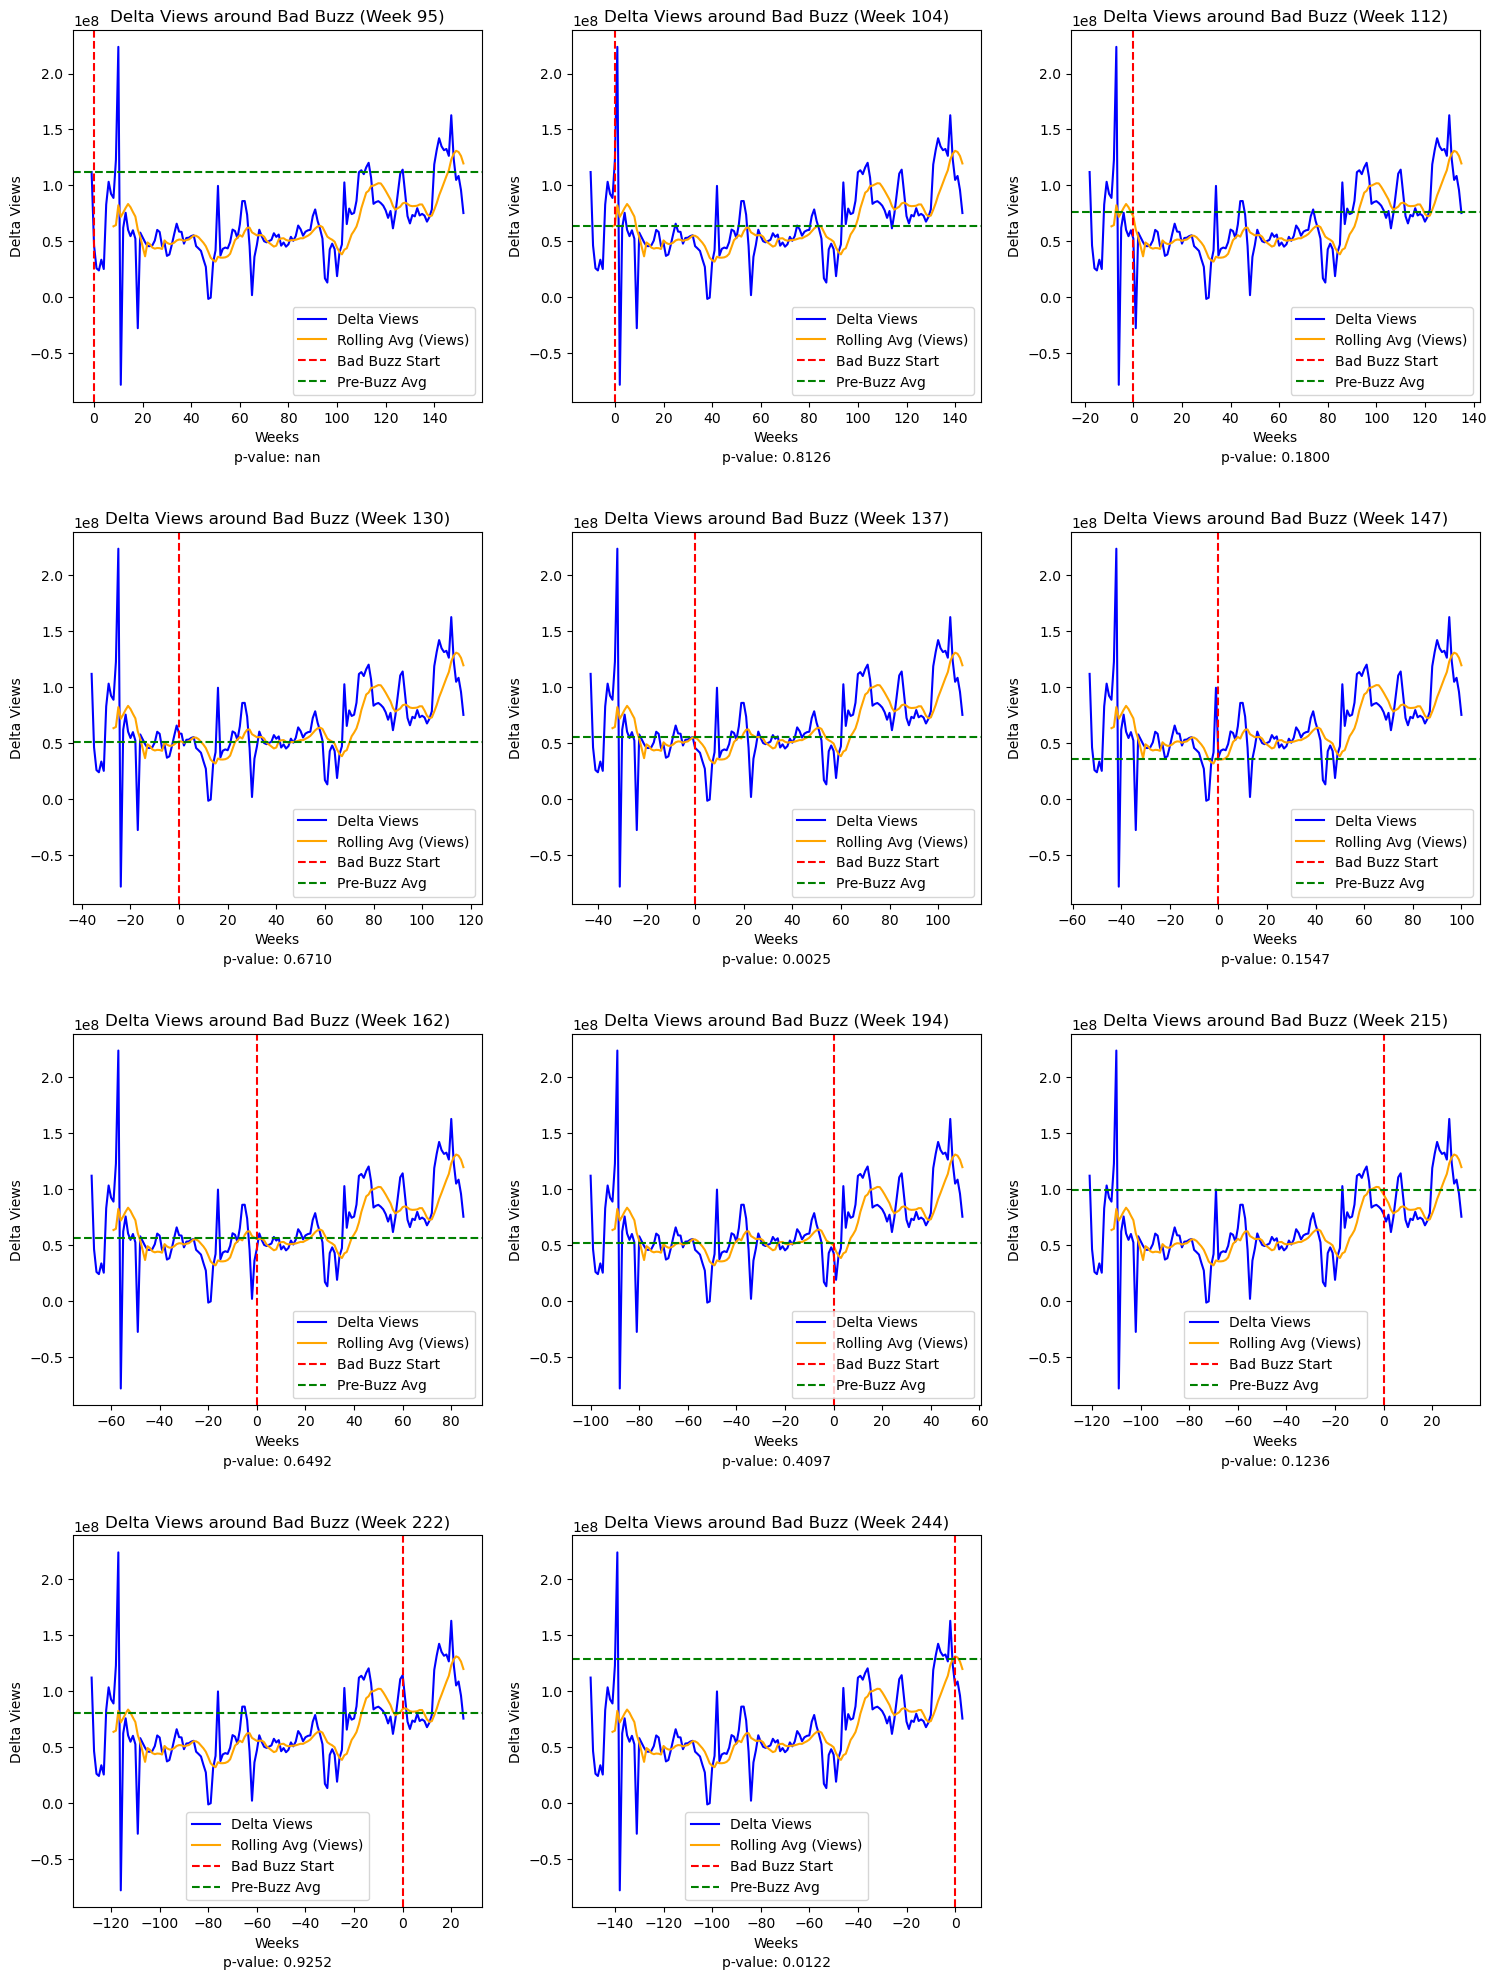

In [75]:
pew_die_pie = data.xs('UC-lHJZR3Gqxm24_Vd_AJ5Yw', level='channel').reset_index()
pew_die_pie_bb_weeks = bad_buzz_df[bad_buzz_df['channel'] == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['week']

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_buzz_views, avg_during_buzz_views, avg_post_buzz_views = calculate_averages(pre_buzz, during_buzz, post_buzz)
    
    p_value = perform_t_test(pre_buzz, during_buzz)
    
    plot_results(axes[i], df_plot, avg_pre_buzz_views, week, p_value)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()

### 3. All Channels 

In [76]:
interactive_plot_views_roll_avg = widgets.interactive_output(analyze_views_around_bad_buzz, {'channel': channel_selector, 
                                                                                            'df': widgets.fixed(data),
                                                                                            'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_views_roll_avg)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

Only a few of the detected periods of interest seem to be correlated with a significant change of views.\
We hypothesize the following:

- **Loss of Interest**: When audience engagement decreases due to a gradual loss of interest or content fatigue, we expect a sustained decrease in delta_views. This pattern reflects a natural decline in audience engagement without significant external attention. In this case, we are not expecting an important change between the `delta_views` averages of the `pre_buzz` and the `during_buzz` periods. It could be interesting to further explore this option by comparing the `pre_buzz` and `post_buzz` averages.

- **Bad Buzz Event**: Conversely, when audience loss is triggered by a negative event (e.g., public backlash or negative media coverage), we hypothesize that there will be an initial temporary spike in views. This increase results from heightened public interest or curiosity, as viewers seek to understand or react to the controversy.

The approach used in this part helps us understand whether significant shifts in views occur around the identified bad buzz periods.

## C. Likes/Dislikes Analysis Around Detected Bad Buzz

After investigating the number of views, we would now like to see if the number dislikes increase and if the number of likes decreases when a channel has a sudden drop of growth.

- Normalize the timeline around each identified bad buzz event
- Compare metrics for pre-buzz, during-buzz, and post-buzz periods:
    - Pre-Buzz: Let's say the 10 weeks leading up to the bad buzz
    - During Buzz: The week of the bad buzz and the 4 weeks following it
    - Post-Buzz: The 10 weeks after the initial bad buzz period
- Key metrics:
    - like_count: The number of likes received during a specific week
    - dislike_count: The number of dislikes received during a specific week
    - Like/Dislike Ratio: Calculated as like_count / (like_count + dislike_count)

- Hypothesis Testing
    - Hypothesis: During a bad buzz, dislike_count should increase, and like_count or the like/dislike ratio should decrease
You can verify this by comparing averages and performing statistical tests to see if there’s a significant change in these metrics during the bad buzz period compared to the pre-buzz period.

In [77]:
def calculate_engagement_averages(pre_buzz, during_buzz):
    avg_pre_likes = pre_buzz['like_count'].mean()
    avg_pre_dislikes = pre_buzz['dislike_count'].mean()
    avg_pre_ratio = (pre_buzz['like_count'] / (pre_buzz['like_count'] + pre_buzz['dislike_count'])).mean()

    avg_during_likes = during_buzz['like_count'].mean()
    avg_during_dislikes = during_buzz['dislike_count'].mean()
    avg_during_ratio = (during_buzz['like_count'] / (during_buzz['like_count'] + during_buzz['dislike_count'])).mean()
    
    return avg_pre_likes, avg_pre_dislikes, avg_pre_ratio, avg_during_likes, avg_during_dislikes, avg_during_ratio

def perform_engagement_t_tests(pre_buzz, during_buzz):
    t_stat_dislikes, p_value_dislikes = ttest_ind(during_buzz['dislike_count'], pre_buzz['dislike_count'], equal_var=False)
    t_stat_ratio, p_value_ratio = ttest_ind(
        during_buzz['like_count'] / (during_buzz['like_count'] + during_buzz['dislike_count']),
        pre_buzz['like_count'] / (pre_buzz['like_count'] + pre_buzz['dislike_count']),
        equal_var=False
    )
    return p_value_dislikes, p_value_ratio

def plot_engagement_results(ax, df, week, p_value_dislikes, p_value_ratio, pos_p_value=-0.15):
    sns.lineplot(data=df, x='relative_week', y='like_count', label='Likes', color='blue', ax=ax)
    sns.lineplot(data=df, x='relative_week', y='dislike_count', label='Dislikes', color='orange', ax=ax)
    ax2 = ax.twinx()
    ax2.plot(df['relative_week'], (df['like_count'] / (df['like_count'] + df['dislike_count'])).rolling(5).mean(), label='Like/Dislike Ratio', color='purple')
    
    ax.axvline(x=0, color='green', linestyle='--', label='Bad Buzz Start')
    
    ax.set_title(f"Likes, Dislikes, and Ratio around Bad Buzz (Week {week})")
    ax.set_xlabel('Weeks Relative to Bad Buzz')
    ax.set_ylabel('Engagement Counts')
    ax2.set_ylabel('Like/Dislike Ratio')
    ax.legend()
    
    # Add p-value text
    ax.text(0.5, pos_p_value, f'p-value (dislikes): {p_value_dislikes:.4f}, p-value (ratio): {p_value_ratio:.4f}', transform=ax.transAxes, ha='center', va='center')

def analyze_engagement_around_bad_buzz(channel, df, bad_buzz_df, pos_p_value=-0.25):
    df_plot = df.xs(channel, level='channel').reset_index()
    bad_buzz_weeks = bad_buzz_df[bad_buzz_df['channel'] == channel]['week']
    
    fig, axes = plt.subplots(6, 4, figsize=(20, 20))
    axes = axes.flatten()
    
    for i, week in enumerate(bad_buzz_weeks):
        df_plot = normalize_week_indices(df_plot, week)
        pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
        
        p_value_dislikes, p_value_ratio = perform_engagement_t_tests(pre_buzz, during_buzz)
        
        plot_engagement_results(axes[i], df_plot, week, p_value_dislikes, p_value_ratio, pos_p_value)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.75)
    plt.show()

### 1. One Channel 

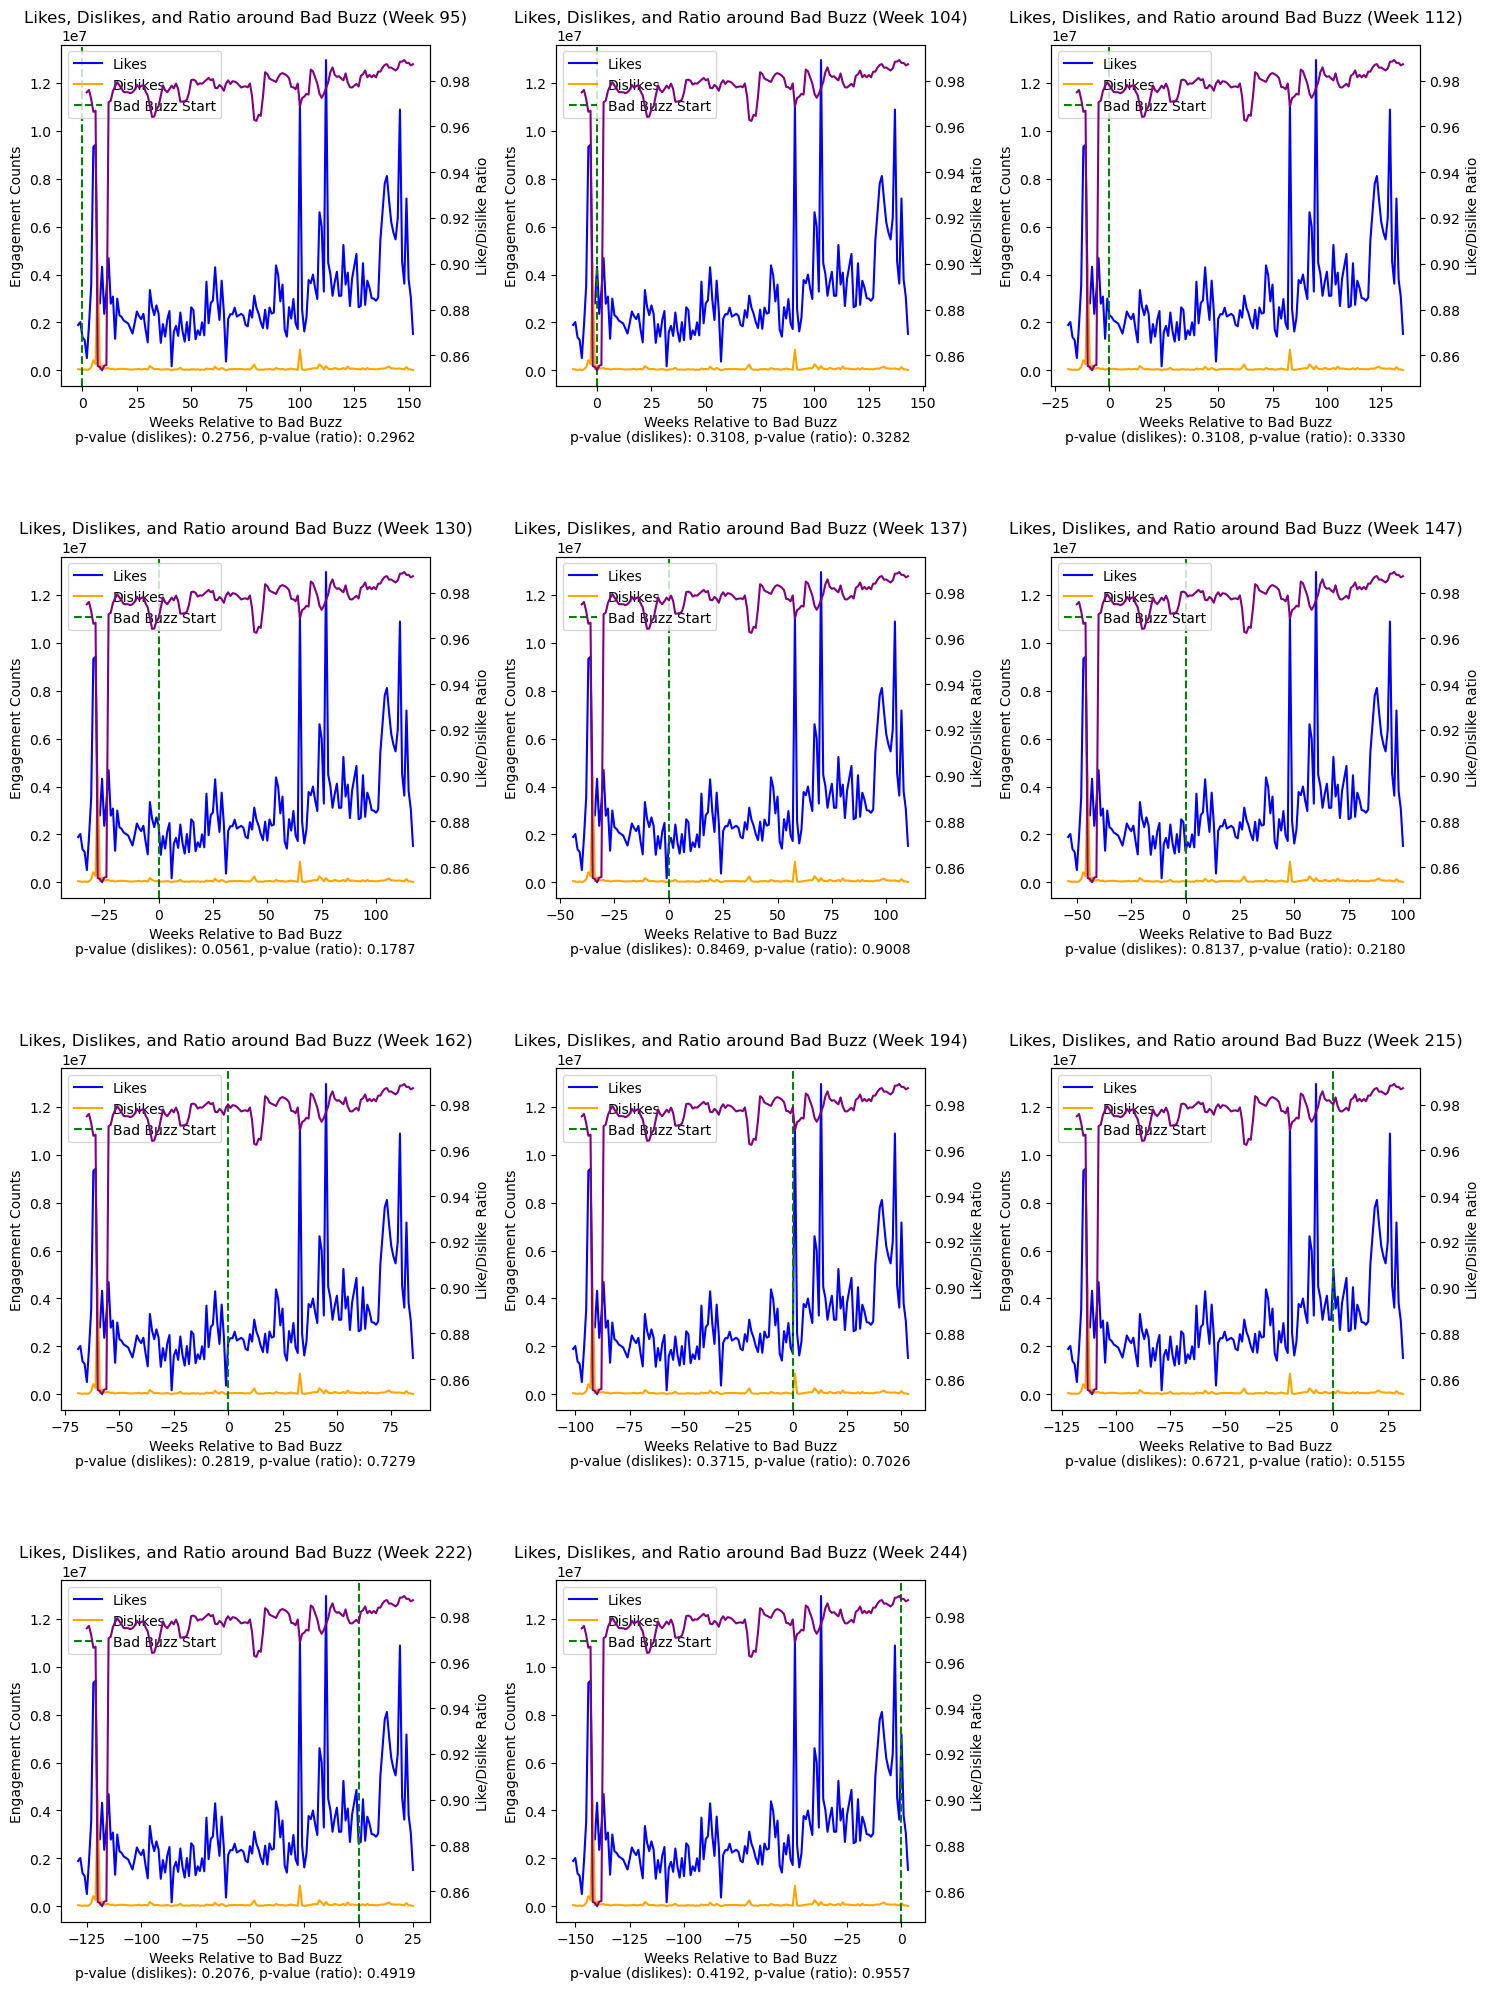

In [78]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_likes, avg_pre_dislikes, avg_pre_ratio, avg_during_likes, avg_during_dislikes, avg_during_ratio = calculate_engagement_averages(pre_buzz, during_buzz)
    
    p_value_dislikes, p_value_ratio = perform_engagement_t_tests(pre_buzz, during_buzz)
    
    plot_engagement_results(axes[i], df_plot, week, p_value_dislikes, p_value_ratio)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

INTERPRETATION : If you see a significant increase in dislikes and a drop in the like/dislike ratio during the bad buzz period (confirmed by low p-values from the t-tests), this would support your hypothesis. The visualizations can also help you understand whether the patterns are consistent across channels or unique to specific cases.

very strange to have the same like/dislike ratio before a BB and after a BB 

### 2. All Channels 

In [79]:
interactive_plot_likes_dislikes = widgets.interactive_output(analyze_engagement_around_bad_buzz, {'channel': channel_selector, 
                                                                                   'df': widgets.fixed(data), 
                                                                                   'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_likes_dislikes)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

## D. Activity around the BB 
In this part, we want to see if the activity of a youtube channel and its growth are correlated.\
HYPOTHESIS:
- An activity lower than usual could induce a down-turn of the growth
- A period of slower growth could be followed by a high- or low- activity, depending on the strategy of the youtube channel

In [80]:
def calculate_activity_averages(pre_buzz, during_buzz, post_buzz):
    avg_pre_activity = pre_buzz['activity'].mean()
    avg_during_activity = during_buzz['activity'].mean()
    avg_post_activity = post_buzz['activity'].mean()
    return avg_pre_activity, avg_during_activity, avg_post_activity

def perform_activity_t_tests(pre_buzz, during_buzz):
    t_stat_activity, p_value_activity = ttest_ind(during_buzz['activity'], pre_buzz['activity'], equal_var=False)
    return p_value_activity

def plot_activity_results(ax, df, avg_pre_activity, week, p_value_activity, pos_p_value=-0.15):
    sns.lineplot(data=df, x='relative_week', y='activity', label='Activity', color='blue', ax=ax)
    ax.axvline(x=0, color='green', linestyle='--', label='Bad Buzz Start')
    ax.axhline(y=avg_pre_activity, color='red', linestyle='--', label='Pre-Buzz Avg')
    
    ax.set_title(f"Activity around Bad Buzz (Week {week})")
    ax.set_xlabel('Weeks Relative to Bad Buzz')
    ax.set_ylabel('Number of Videos Posted')
    ax.legend()
    
    ax.text(0.5, pos_p_value, f'p-value (dislikes): {p_value_activity:.4f}', transform=ax.transAxes, ha='center', va='center')

def analyze_activity_around_bad_buzz(channel, df, bad_buzz_df, pos_p_value=-0.25):
    df_plot = df.xs(channel, level='channel').reset_index()
    bad_buzz_weeks = bad_buzz_df[bad_buzz_df['channel'] == channel]['week']
    
    fig, axes = plt.subplots(6, 4, figsize=(20, 20))
    axes = axes.flatten()
    
    for i, week in enumerate(bad_buzz_weeks):
        df_plot = normalize_week_indices(df_plot, week)
        pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
        avg_pre_activity, avg_during_activity, avg_post_activity = calculate_activity_averages(pre_buzz, during_buzz, post_buzz)
        
        p_value_activity = perform_activity_t_tests(pre_buzz, during_buzz)
        
        plot_activity_results(axes[i], df_plot, avg_pre_activity, week, p_value_activity, pos_p_value)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.75)
    plt.show()

### 1. For One Channel

c:\Users\eva\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\eva\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


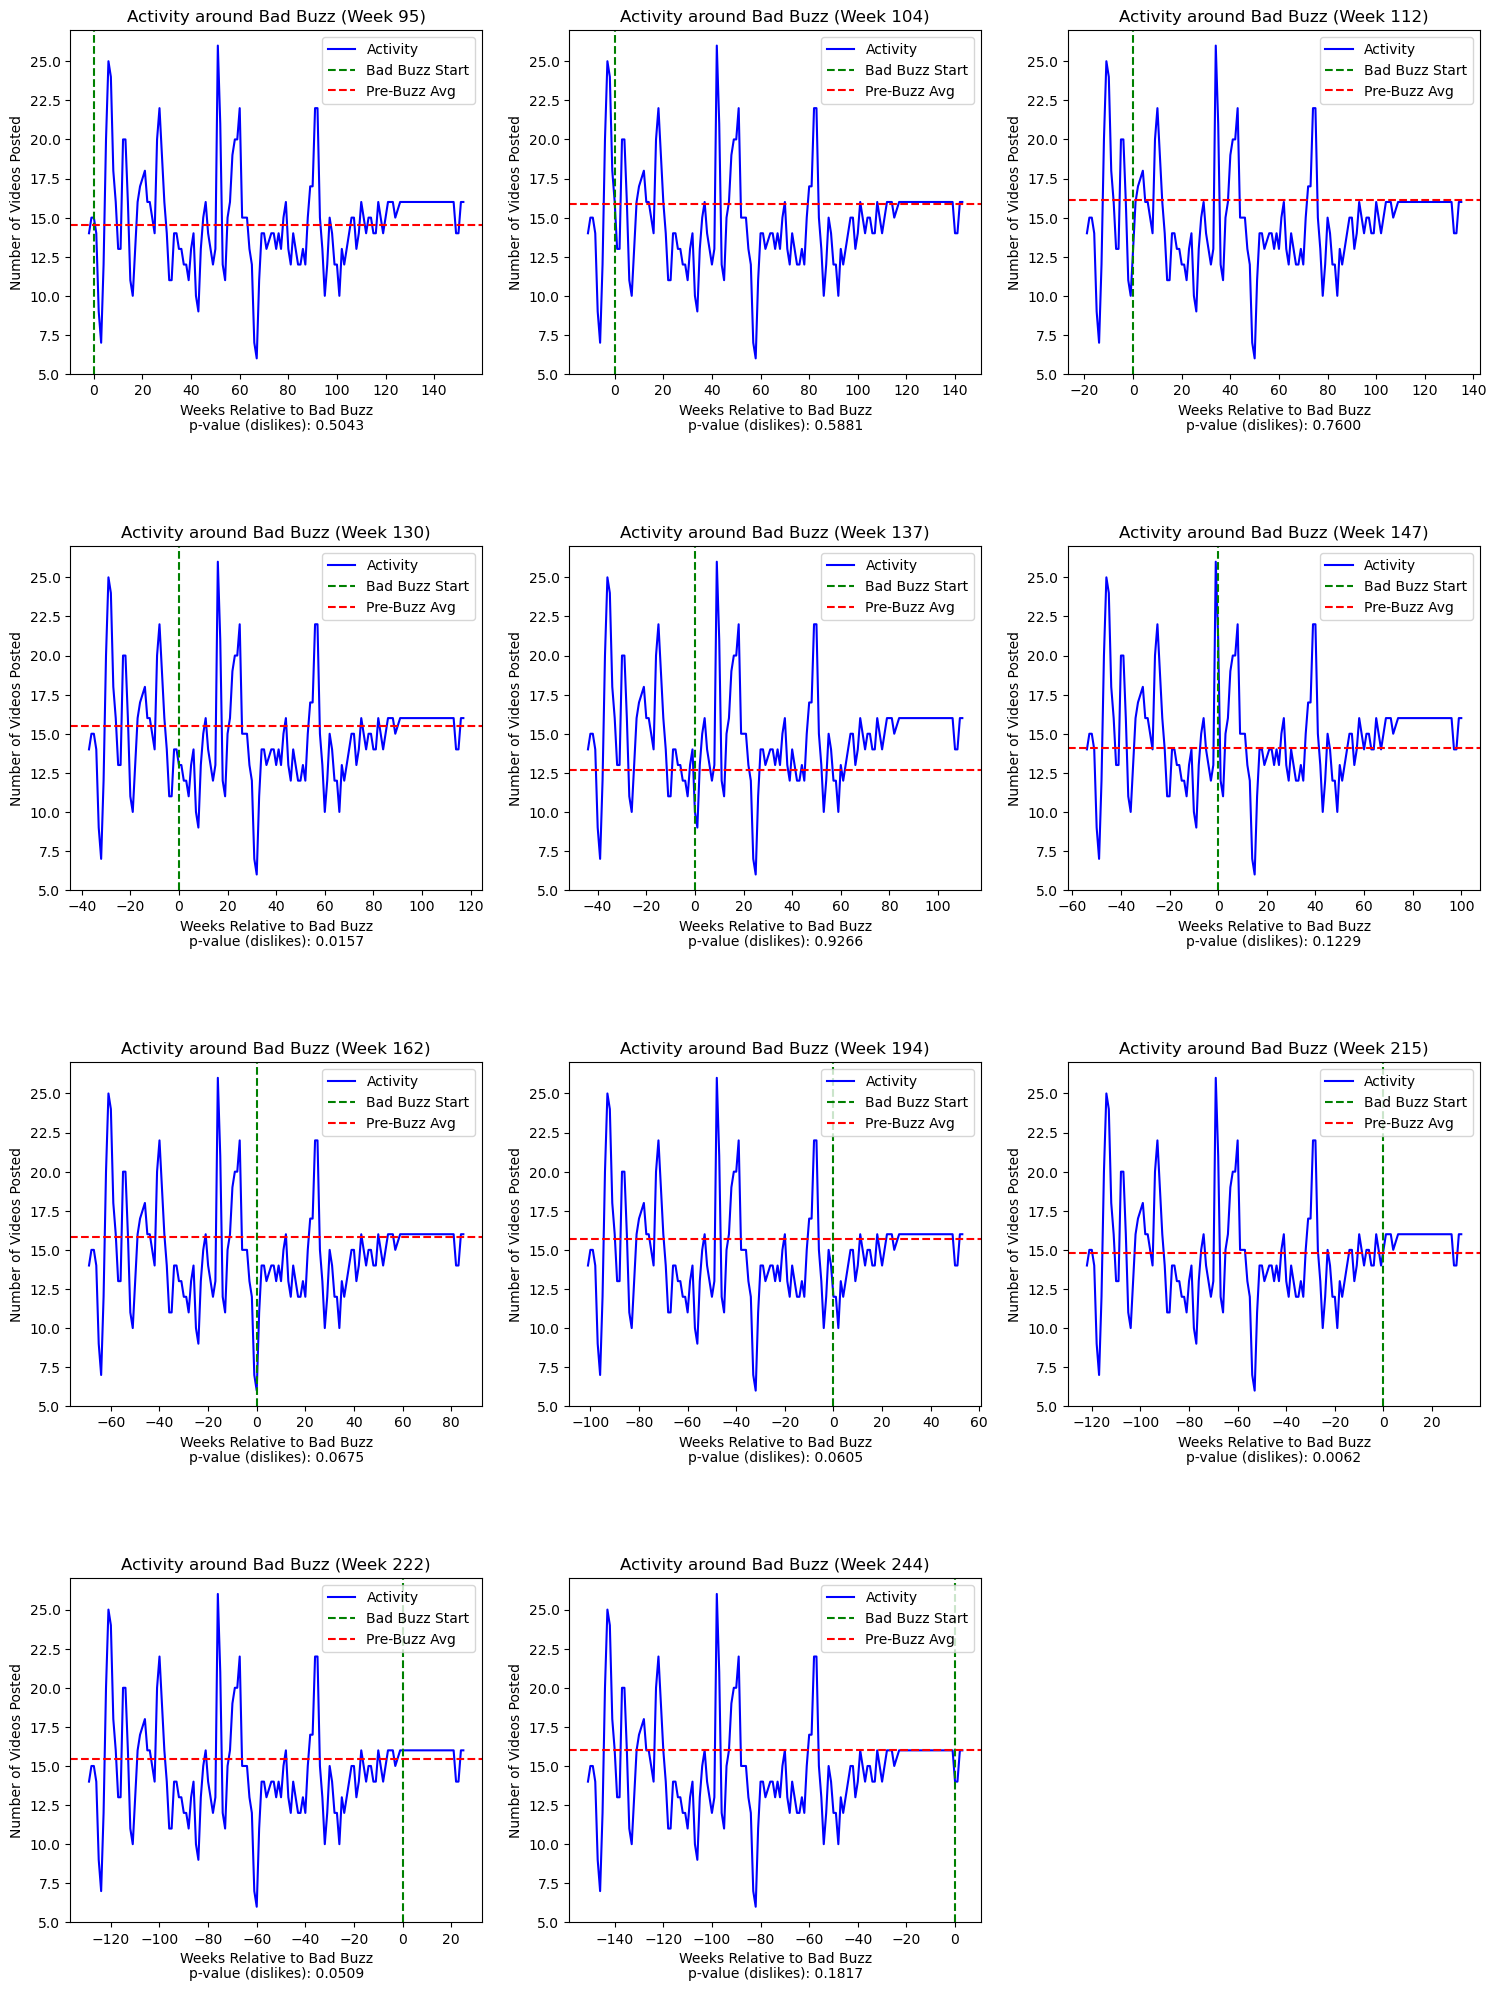

In [81]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

for i, week in enumerate(pew_die_pie_bb_weeks):
    df_plot = normalize_week_indices(pew_die_pie, week)
    pre_buzz, during_buzz, post_buzz = define_periods(df_plot)
    avg_pre_activity, avg_during_activity, avg_post_activity = calculate_activity_averages(pre_buzz, during_buzz, post_buzz)
    
    p_value_activity = perform_activity_t_tests(pre_buzz, during_buzz)
    
    plot_activity_results(axes[i], df_plot, avg_pre_activity, week, p_value_activity)
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

### 2. For All Channels 

In [82]:
interactive_plot_activity = widgets.interactive_output(analyze_activity_around_bad_buzz, {'channel': channel_selector, 
                                                                                          'df': widgets.fixed(data), 
                                                                                          'bad_buzz_df': widgets.fixed(bad_buzz_df)})
display(channel_selector, interactive_plot_activity)

SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC0v-tlzsn0QZwJnkiaUSJVQ', 'UC1r…

Output()

# III. Data Analysis On All Dataset 

## A. Subscribers Analysis

### 1. Subscribers plot for each channel

In [83]:
# Create a SelectionSlider widget for selecting channels
channel_selector_original = SelectionSlider(
    options=original_data.index.get_level_values('channel').unique(),
    description='Channel:',
    disabled=False
)
interactive_plot_original = widgets.interactive_output(plot_subs_by_channel, {'channel': channel_selector_original, 'df': widgets.fixed(original_data)})
display(channel_selector_original, interactive_plot_original)

SelectionSlider(description='Channel:', options=('UC--24Q3_ZQeFmgJE-Um5QZQ', 'UC--2EbuIuBOGgGqPiJxi3rg', 'UC--…

Output()

### 2. Rolling average analysis 

In [84]:
# smaller_original_data = original_data[['delta_subs']]
# smaller_original_data = smaller_original_data.reset_index()

In [85]:
# ROLLING_WINDOW = 20

# # Initialize the new column with NaN values of the appropriate data type
# smaller_original_data['rolling_growth_rate'] = np.nan

# # Get the unique channels
# channels = smaller_original_data['channel'].unique()

# # Iterate over each channel and calculate the rolling mean
# for channel in tqdm(channels, desc="Calculating rolling growth rate"):
#     channel_data = smaller_original_data[smaller_original_data['channel'] == channel]
#     rolling_mean = channel_data['delta_subs'].rolling(ROLLING_WINDOW, min_periods=1).mean()
#     smaller_original_data.loc[smaller_original_data['channel'] == channel, 'rolling_growth_rate'] = rolling_mean

# smaller_original_data

In [86]:
# ROLLING_WINDOW = 20
# THRESHOLD_BB = 0 #TODO: try to modify it so that it doesn't detect the small BB

# original_data['rolling_growth_rate'] = original_data.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(ROLLING_WINDOW, min_periods=1).mean())
# original_data['growth_diff'] = original_data['delta_subs'] - original_data['rolling_growth_rate']

# # Detection of period where growth_rate < rolling_growth_rate
# original_data['is_bad_buzz'] = original_data['growth_diff'] < THRESHOLD_BB
# # Create a DataFrame that contains only the starting week of each BBC
# bad_buzz_starts = []

# # For loop to detect the starting week of BB
# for channel in original_data.reset_index()['channel'].unique():
#     channel_data = original_data.reset_index()[original_data.reset_index()['channel'] == channel]
    
#     # Identify indices where BB has started
#     for i in range(1, len(channel_data)):
#         if channel_data['is_bad_buzz'].iloc[i] and not channel_data['is_bad_buzz'].iloc[i-1]:
#             bad_buzz_starts.append({'channel': channel, 'week': channel_data['week'].iloc[i]})

# bad_buzz_df_original = pd.DataFrame(bad_buzz_starts).reset_index()[['channel', 'week']]

# bad_buzz_df_original

In [96]:
df_with_rgr = pd.read_csv('df_with_rgr.tsv', sep='\t')
events = pd.read_csv('event.tsv', sep='\t')

In [100]:
df_with_rgr.head()
print(df_with_rgr.columns)

Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count', 'dislike_count',
       'rolling_growth_rate', 'growth_diff', 'is_bad_buzz'],
      dtype='object')


In [99]:
events.shape

(504, 2)

In [87]:
channel_selector_original = SelectionSlider(
    options=original_data.index.get_level_values('channel').unique(),
    description='Channel:',
    disabled=False
)

In [88]:
interactive_plot_subs_roll_avg_original = widgets.interactive_output(plot_rolling_growth_rate, {'channel': channel_selector_original, 
                                                                                                'df': widgets.fixed(original_data), 
                                                                                                'bad_buzz_df': widgets.fixed(bad_buzz_df_original)})
display(channel_selector_original, interactive_plot_subs_roll_avg_original)

NameError: name 'bad_buzz_df_original' is not defined

## B. Views Analysis around Detected BB

### 1. Delta Views Evolution In General

In [ ]:
interactive_plot_views_original = widgets.interactive_output(plot_views_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                        'df': widgets.fixed(original_data), 
                                                                                        'bad_buzz_df': widgets.fixed(bad_buzz_df_original)})
display(channel_selector_original, interactive_plot_views_original)

### 2. Delta Views Evolution in around BB

In [ ]:
interactive_plot_views_roll_avg_original = widgets.interactive_output(analyze_views_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                                    'df': widgets.fixed(original_data), 
                                                                                                    'bad_buzz_df': widgets.fixed(bad_buzz_df_original)})
display(channel_selector_original, interactive_plot_views_roll_avg_original)

## C. Likes/Dislikes Analysis

In [ ]:
interactive_plot_likes_dislikes_original = widgets.interactive_output(analyze_engagement_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                                            'df': widgets.fixed(original_data), 
                                                                                                            'bad_buzz_df': widgets.fixed(bad_buzz_df_original)})
display(channel_selector_original, interactive_plot_likes_dislikes_original)

## D. Activity Analysis

In [ ]:
interactive_plot_activity_original = widgets.interactive_output(analyze_activity_around_bad_buzz, {'channel': channel_selector_original, 
                                                                                                    'df': widgets.fixed(original_data), 
                                                                                                    'bad_buzz_df': widgets.fixed(bad_buzz_df_original)})
display(channel_selector_original, interactive_plot_activity_original)

## E. Various Plots

In [116]:
# data.head()
bad_buzz_df.head()
print("Shape of bad_buzz_df: ", bad_buzz_df.shape, 
      "\nShape of data: ", data.shape, 
      "\nShape of df_with_rgr: ", df_with_rgr.shape, 
      "\nShape of original df: ", original_data.shape)

Shape of bad_buzz_df:  (504, 2) 
Shape of data:  (5030, 14) 
Shape of df_with_rgr:  (18604824, 14) 
Shape of original df:  (18604824, 11)


We can merge the two dataframes `df_with_rgr`and `original_df` on their common columns:

In [118]:
original_data.head()

category      views  delta_views  \
channel                  week                                            
UC--24Q3_ZQeFmgJE-Um5QZQ 82    Travel & Events  62524.500          NaN   
                         83    Travel & Events  67600.250     5075.750   
                         84    Travel & Events  69982.000     2381.750   
                         85    Travel & Events  72663.125     2681.125   
                         86    Travel & Events  75093.000     2429.875   

                                   subs  delta_subs  videos  delta_videos  \
channel                  week                                               
UC--24Q3_ZQeFmgJE-Um5QZQ 82    1466.000         NaN      29           NaN   
                         83    1508.625      42.625      30           1.0   
                         84    1530.750      22.125      31           1.0   
                         85    1558.625      27.875      32           1.0   
                         86    1591.000      32.375      33           1.0   

                               activity  view_count  like_count  dislike_count  
channel                  week                                                   
UC--24Q3_ZQeFmgJE-Um5QZQ 82           1      5849.0       222.0            1.0  
                         83           2      5336.0       204.0            1.0  
                         84           2      5727.0       232.0            1.0  
                         85           2     19214.0       318.0            7.0  
                         86           2      6949.0       234.0            1.0

In [120]:
print(df_with_rgr.columns)

original_data = original_data.reset_index()
print(original_data.columns)

# Now merge the DataFrames on 'week' and 'channel'
merged_df = df_with_rgr.merge(original_data, on=['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count', 'dislike_count'])

# Display the shape of the merged DataFrame to confirm the result
print(f"Shape of merged DataFrame: {merged_df.shape}")

Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count', 'dislike_count',
       'rolling_growth_rate', 'growth_diff', 'is_bad_buzz'],
      dtype='object')
Index(['index', 'channel', 'week', 'category', 'views', 'delta_views', 'subs',
       'delta_subs', 'videos', 'delta_videos', 'activity', 'view_count',
       'like_count', 'dislike_count'],
      dtype='object')
Shape of merged DataFrame: (18388785, 17)


In [122]:
merged_df = merged_df.merge(events, on=['channel'])
print(merged_df.columns)
print("Shape of our df: ", merged_df.shape)

Index(['category', 'views', 'delta_views', 'subs', 'delta_subs', 'videos',
       'delta_videos', 'activity', 'view_count', 'like_count', 'dislike_count',
       'rolling_growth_rate', 'growth_diff', 'is_bad_buzz', 'index', 'channel',
       'week_x', 'week_y'],
      dtype='object')
Shape of our df:  (76054, 18)


In [123]:
merged_df.head(20)

,category,views,delta_views,subs,delta_subs,videos,delta_videos,activity,view_count,like_count,dislike_count,rolling_growth_rate,growth_diff,is_bad_buzz,index,channel,week_x,week_y
0,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,95
1,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,104
2,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,112
3,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,130
4,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,137
5,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,147
6,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,162
7,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,194
8,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,215
9,Gaming,1.357761e+10,NaN,4.861796e+07,NaN,2906,NaN,14,45210757.0,1892943.0,51248.0,NaN,NaN,False,222663,UC-lHJZR3Gqxm24_Vd_AJ5Yw,93,222


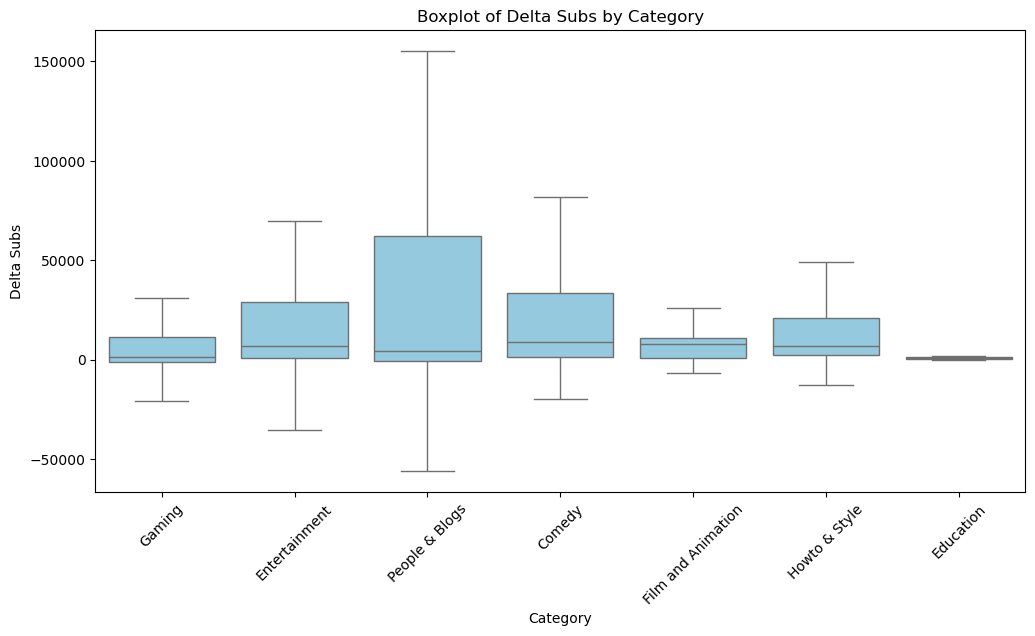

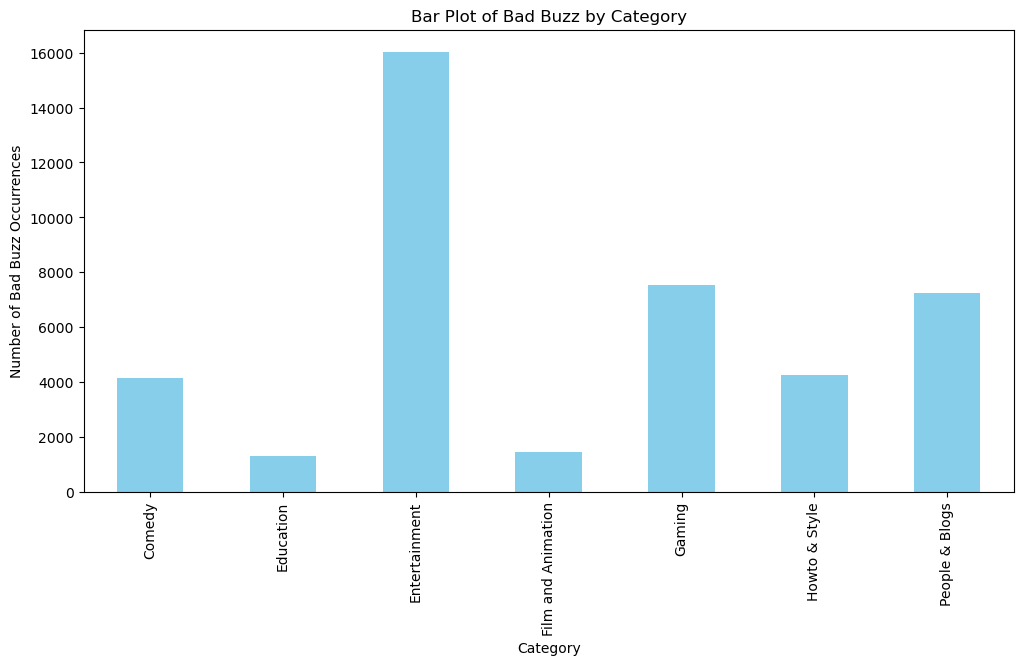

In [124]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x='category', y='delta_subs', color='skyblue', showfliers=False)
plt.xticks(rotation=45)
plt.title('Boxplot of Delta Subs by Category')
plt.xlabel('Category')
plt.ylabel('Delta Subs')
plt.show()

bad_buzz_counts = merged_df[merged_df['is_bad_buzz']].groupby('category').size()

plt.figure(figsize=(12, 6))
bad_buzz_counts.plot(kind='bar', color='skyblue')
plt.title('Bar Plot of Bad Buzz by Category')
plt.xlabel('Category')
plt.ylabel('Number of Bad Buzz Occurrences')
plt.show()

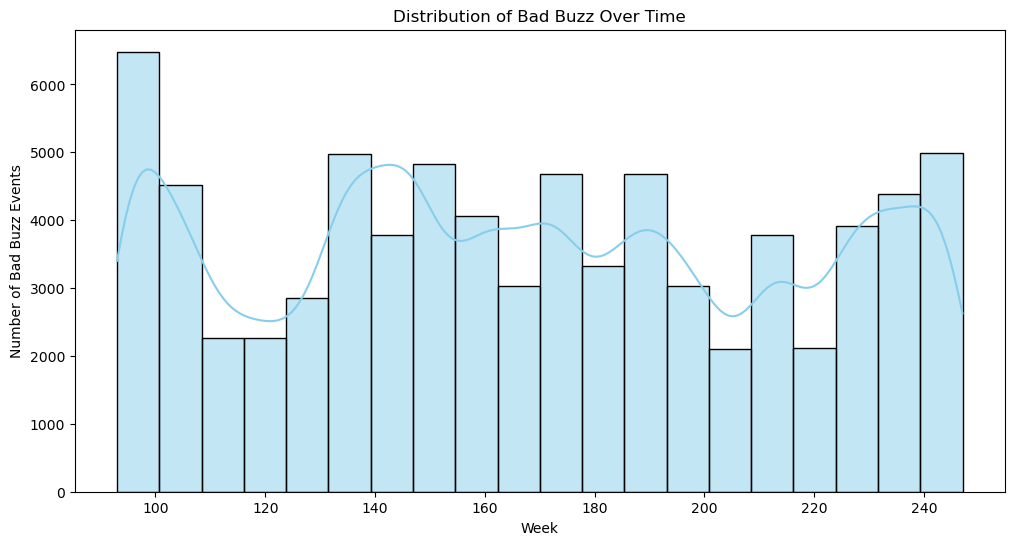

In [127]:
plt.figure(figsize=(12, 6))
sns.histplot(merged_df['week_y'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Bad Buzz Over Time')
plt.xlabel('Week')
plt.ylabel('Number of Bad Buzz Events')
plt.show()

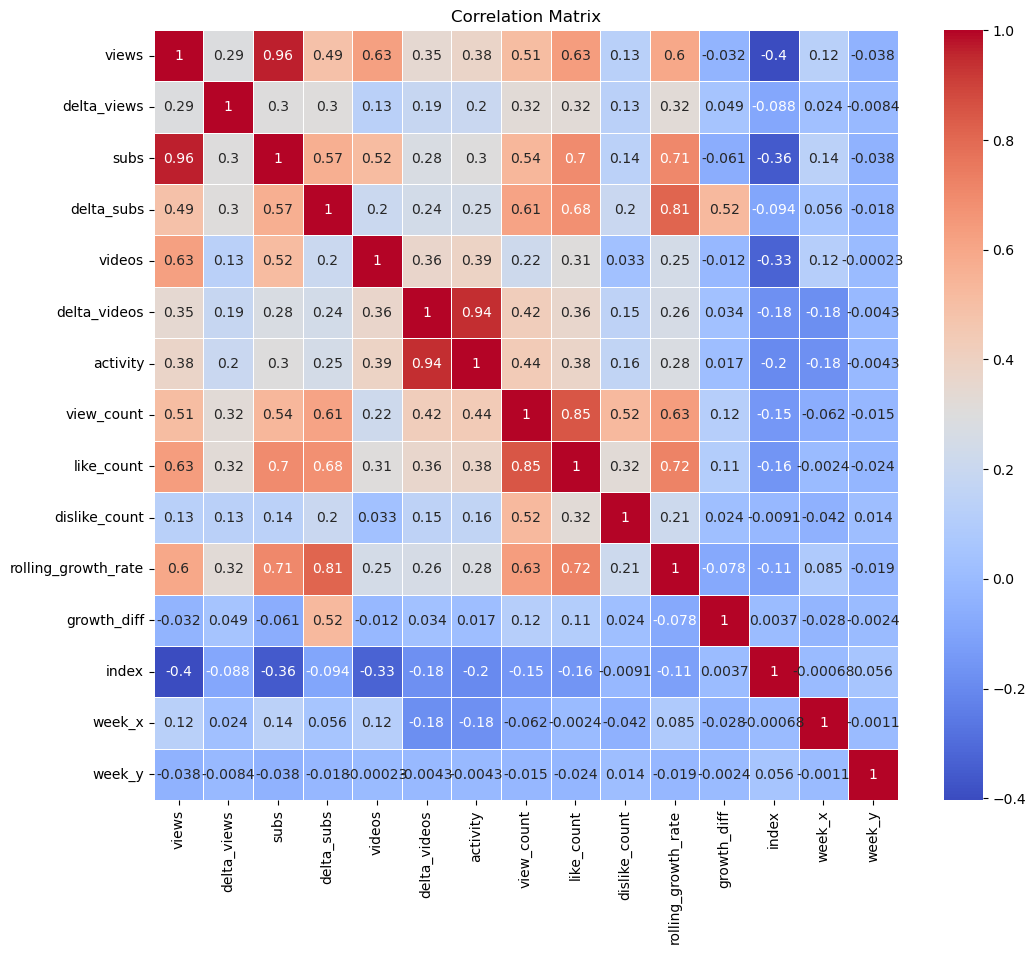

In [165]:
plt.figure(figsize=(12, 10))
numeric_df = merged_df.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

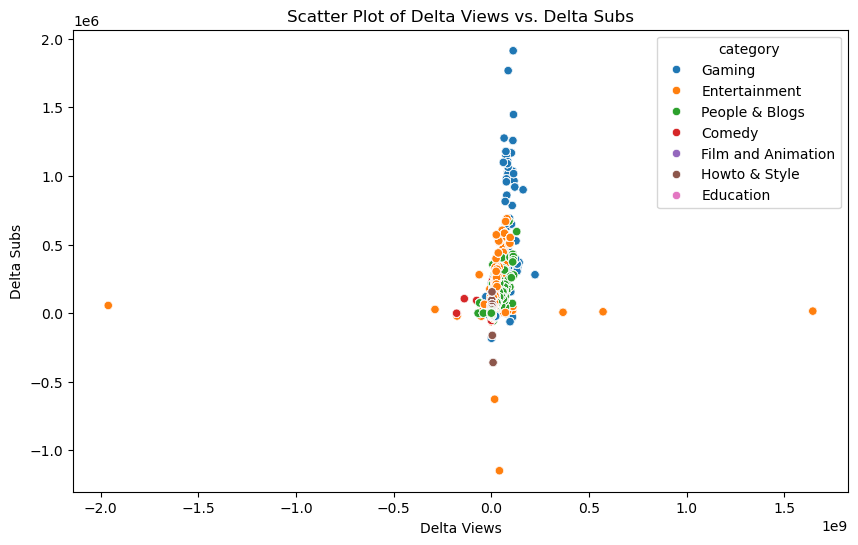

In [131]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='delta_views', y='delta_subs', hue='category')
plt.title('Scatter Plot of Delta Views vs. Delta Subs')
plt.xlabel('Delta Views')
plt.ylabel('Delta Subs')
plt.show()

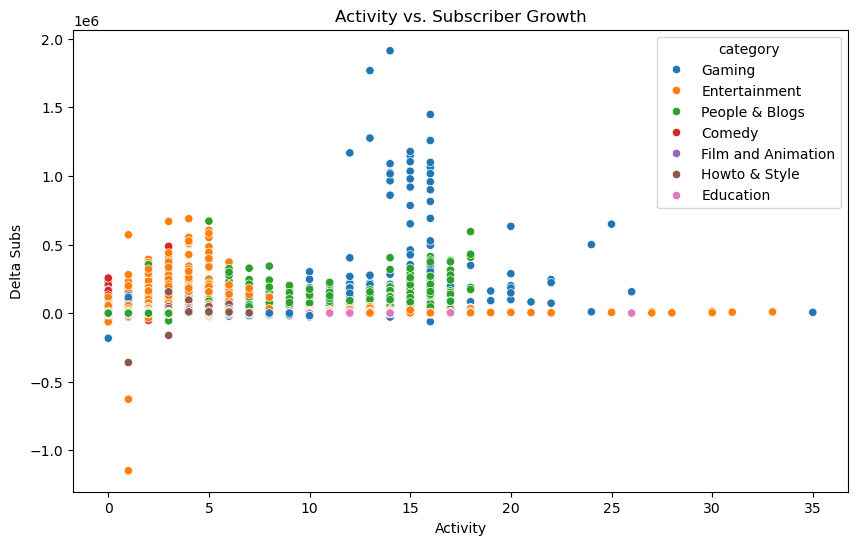

In [133]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='activity', y='delta_subs', hue='category')
plt.title('Activity vs. Subscriber Growth')
plt.xlabel('Activity')
plt.ylabel('Delta Subs')
plt.show()

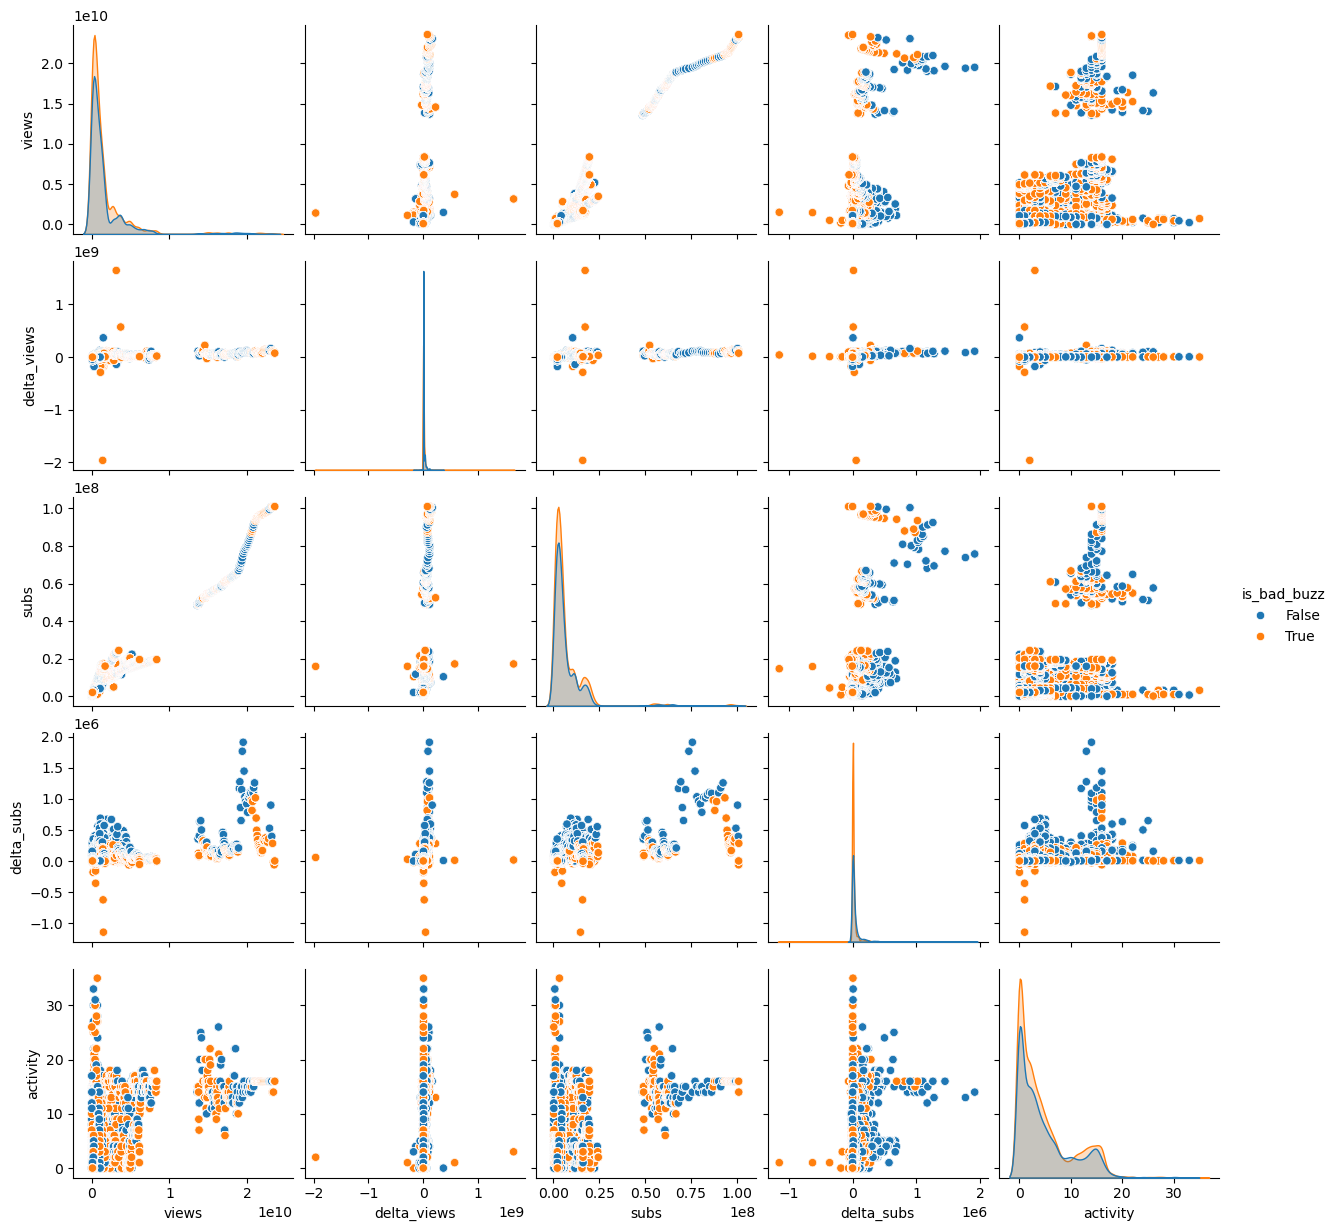

In [141]:
sns.pairplot(merged_df, vars=['views', 'delta_views', 'subs', 'delta_subs', 'activity'], hue='is_bad_buzz')
plt.show()

In [150]:
data = merged_df[['category', 'channel', 'week_y']].drop_duplicates()
data = data.rename(columns={'week_y': 'event'})
data.head()

,category,channel,event
0,Gaming,UC-lHJZR3Gqxm24_Vd_AJ5Yw,95
1,Gaming,UC-lHJZR3Gqxm24_Vd_AJ5Yw,104
2,Gaming,UC-lHJZR3Gqxm24_Vd_AJ5Yw,112
3,Gaming,UC-lHJZR3Gqxm24_Vd_AJ5Yw,130
4,Gaming,UC-lHJZR3Gqxm24_Vd_AJ5Yw,137


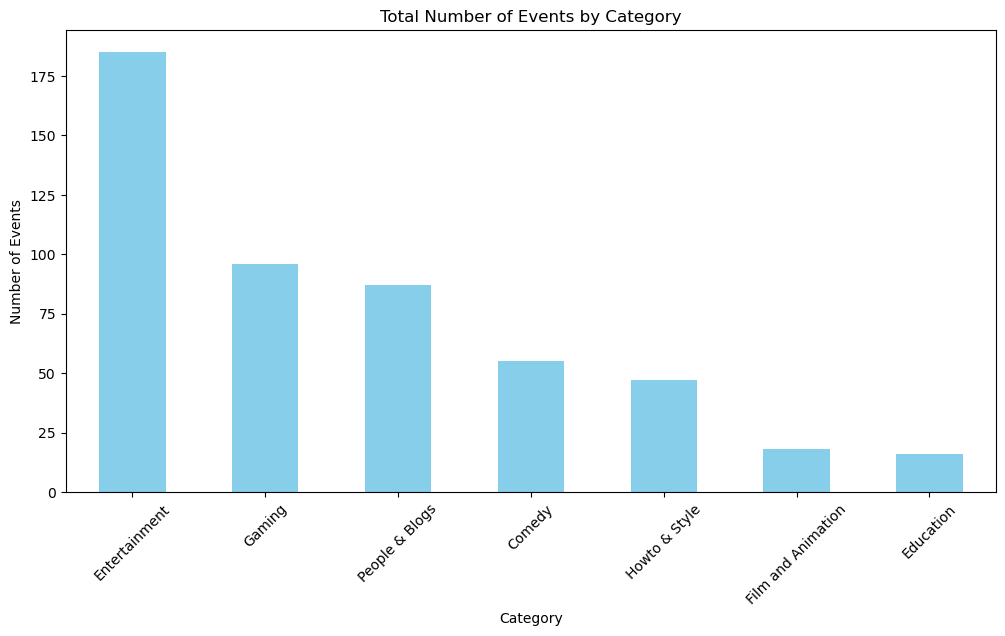

In [162]:
category_counts = data['category'].value_counts()
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Total Number of Events by Category')
plt.xlabel('Category')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.show()